<a href="https://colab.research.google.com/github/Immisslerick/Call-Screener/blob/main/Determining_Dog_Breeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dog breed prediction

In [ ]:
#Run this cell and select the kaggle.json file downloaded
#from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"immisslerick","key":"ec0c5e5632370dfefa3fc2e089682cc2"}'}

We will start by connecting to Kaggle using Kaggle API which can ve downloaded from your Kaggle account's settings and ploading git here(upload box)

In [ ]:
# Next, install the Kaggle API client
!pip install -q kaggle

Next we will install Kaggle API using pip installation

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#This permissions change avoids a worning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json


Setting up Kaggle usin gKaggle API

In [ ]:
#Creating directory and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

mkdir: cannot create directory ‘dog_dataset’: File exists
/content/dog_dataset


To store the data we will create a new directory and make it as current working directory

In [ ]:
# Searching for dataset
!kaggle datasets list -s dogbreedidfromcomp


ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           4551          8  0.1764706        


Searching Kaggle for the required dataset using search option(-s) with title 'dogbreedidfromcomp'. We can also use different search optioons like searching competitions, notebooks, kernels datasets, etc.

In [ ]:
# Downloading dataset and coming out of directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

100% 691M/691M [00:28<00:00, 44.1MB/s]
100% 691M/691M [00:28<00:00, 25.4MB/s]
/content


After Searching the data next step would be downloading the data into collab notebook using references found in search option.

In [ ]:
# Unzipping downloaded file and removing unusable file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset/
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv


rm: cannot remove 'dog_dataset/sample_submission.csv': No such file or directory


We will unzip the data which is downloaded and remove the irrelevent files.

In [ ]:
# Important library impots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

Importing required libraries.

In [ ]:
# Read the labels.csv file and checking shape and records
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Loading the labels data into datafram and viewing it. Here we analysed that labels contains 10222 rows and 2 columns.

In [ ]:
# Visualize thenumber of each breeds
breeds_all = labels_all["breed"]
breed_count = breeds_all.value_counts()
breed_count.head()


scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

Here we are finding out the count per class i.e. total data in each class using value_counts() function.

In [ ]:
# Selecting first 3 breeds (Limitation due to computation power)
CLASS_NAMES = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()


,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [ ]:
# Creating numpy matri with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

#Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0

# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape:  ',Y_data.shape,' size: {:,}'.format(Y_data.size))


100%|██████████| 357/357 [00:00<00:00, 641.95it/s]


Train Images shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:   (357, 3)  size: 1,071


As we are working with the classification dataset first we need to one hot encode the target value I.e. the classes. After that we will read images and convert them into numpy array and finally normalizing the array.


In [ ]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size =  (5, 5), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size = (3,3 ), activation='relu', kernel_regularizer = 'l2'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size = (7,7), activation='relu', kernel_regularizer = 'l2'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters= 8, kernel_size = (5, 5), activation='relu', kernel_regularizer = 'l2'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer = 'l2'))
model.add(Dense(64, activation='relu', kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001), metrics = ['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 16)       

Next we will create a network architecture for the model. We ahve used different types of layers according to their features namely Conv_2d (It is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten (It flattens the input and creates a 1D output), Dense (Dense layer produce the output as the dot product of input and kernel).

In [ ]:
# Splitting the data seet into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.10)
# Splitting the training gdata seet into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)


After defining the network architecture we will start with splitting the test and train data then dividing train data in train and validation data.


In [ ]:
# Training the model
epochs = 1000
batch_size = 128

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=10, verbose=0, mode="min", baseline=None, restore_best_weights=True, start_from_epoch=100)


history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), callbacks=[early_stopping])


Epoch 1/1000
2/2 [==============================] - 7s 4s/step - loss: 1.4450 - accuracy: 0.9531 - val_loss: 1.6093 - val_accuracy: 0.8923
Epoch 2/1000
2/2 [==============================] - 7s 3s/step - loss: 1.4278 - accuracy: 0.9648 - val_loss: 1.6304 - val_accuracy: 0.8615
Epoch 3/1000
2/2 [==============================] - 6s 3s/step - loss: 1.4283 - accuracy: 0.9727 - val_loss: 1.6419 - val_accuracy: 0.8462
Epoch 4/1000
2/2 [==============================] - 6s 3s/step - loss: 1.4172 - accuracy: 0.9727 - val_loss: 1.6219 - val_accuracy: 0.8923
Epoch 5/1000
2/2 [==============================] - 7s 3s/step - loss: 1.4068 - accuracy: 0.9766 - val_loss: 1.6166 - val_accuracy: 0.8923
Epoch 6/1000
2/2 [==============================] - 7s 3s/step - loss: 1.4056 - accuracy: 0.9727 - val_loss: 1.6187 - val_accuracy: 0.8923
Epoch 7/1000
2/2 [==============================] - 6s 3s/step - loss: 1.3934 - accuracy: 0.9844 - val_loss: 1.6347 - val_accuracy: 0.8769
Epoch 8/1000
2/2 [=========

Now we will train the model until it is no longer improving to avoid overfitting.

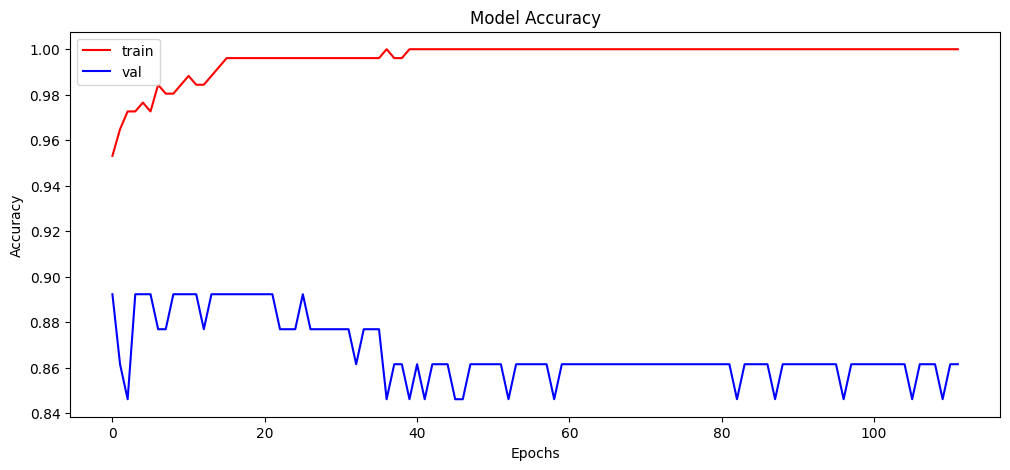

In [ ]:
# Plot the training history
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

here we anaylyse how the model is learning with each epoch in terms of accuracy.


In [ ]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
accuracy = score[1]  # Accuracy is usually the second element of the score list

print('Accuracy over the test set: {:.2f}%'.format(accuracy * 100))


2/2 [==============================] - 0s 24ms/step - loss: 1.4305 - accuracy: 0.9167
Accuracy over the test set: 91.67%
